In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


# Importing Libraries

In [ ]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model


## Setting up Kaggle API to download and use datasets

In [ ]:
!pip install -q kaggle
! mkdir ~/.kaggle

!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

# downloading and unzipping data

In [ ]:
# ! kaggle datasets download vaishaligbhujade/soybean-leaf-dataset-for-disease-classification
# !unzip /content/drive/MyDrive/soybean-leaf-dataset-for-disease-classification.zip -d /content/drive/MyDrive/soybean-leaf-dataset

In [ ]:
dirss = os.listdir('soybean leaf/soybean-leaf-dataset/')
labs = pd.Series(dirss).to_dict()
labs

{0: 'Bacterial Pustule',
 1: 'Frogeye Leaf Spot',
 2: 'Healty',
 3: 'Rust',
 4: 'Sudden Death Syndrome',
 5: 'Target Leaf Spot',
 6: 'Yellow Mosaic'}

### Loading and preprocessing images data

In [ ]:
def load_and_preprocess_data(root_directory, image_size=(224, 224)):
    image_data = []
    labels = []
    class_names = os.listdir(root_directory)
    num_classes = len(class_names)

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(root_directory, class_name)
        image_files = os.listdir(class_path)

        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            image = Image.open(image_path)
            image = image.resize(image_size)
            image_array = np.array(image)
            image_data.append(image_array)
            labels.append(class_index)

    image_data = np.array(image_data)
    labels = np.array(labels)
    return image_data, labels

root_directory = 'soybean leaf/soybean-leaf-dataset/'
x, y = load_and_preprocess_data(root_directory)

We have saved the extracted features of images so that we do not have to process images again

In [ ]:
# joblib.dump(x, 'soybean leaf/leaf_xdata.joblib')
# joblib.dump(y, 'soybean leaf/leaf_ydata.joblib')
XX = joblib.load('soybean leaf/leaf_xdata.joblib')
YY = joblib.load('soybean leaf/leaf_ydata.joblib')

# Splitting data to training and testing set

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(XX, YY, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(693, 224, 224, 3)
(693,)
(77, 224, 224, 3)
(77,)


# visualizing some random images with lables


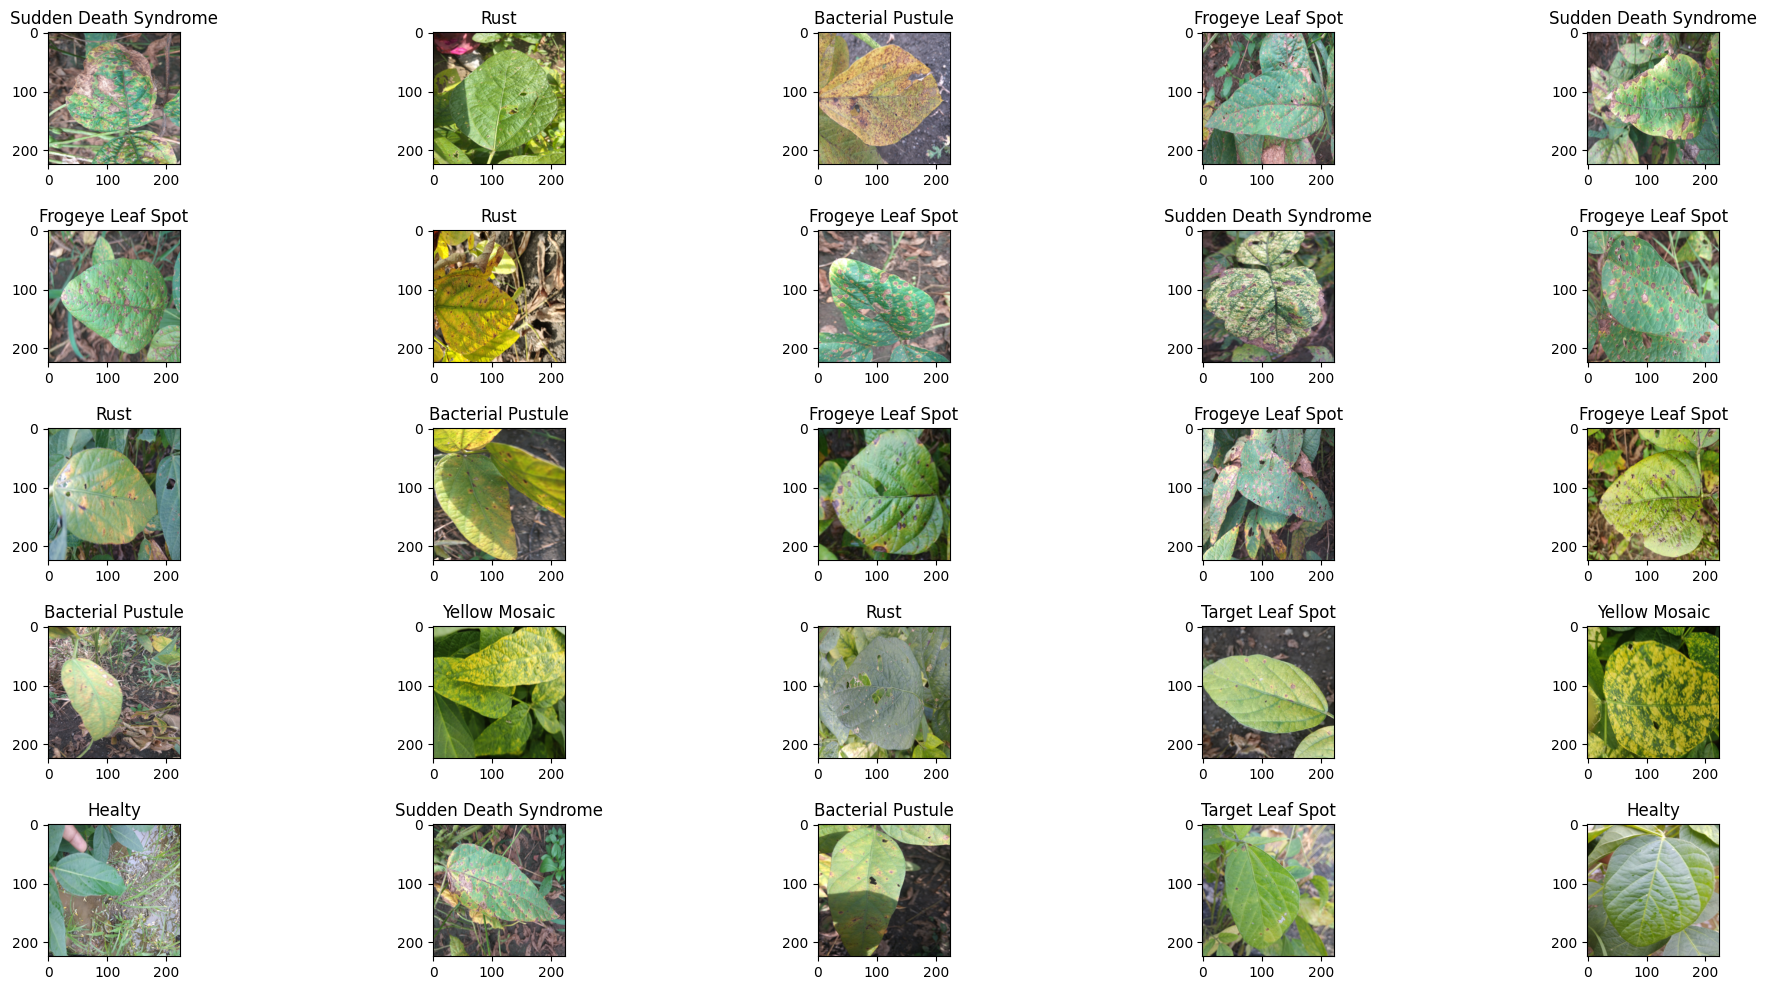

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(24, 12))
fig.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes.flat):
    index = y_train[i]
    ax.imshow(x_train[i])
    ax.set_title(labs[index])
# Show the plot
plt.show()

### converting y data to categorical (7 categories here)

In [ ]:
# x__train = x_train / 255.0
# x__test = x_test / 255.0

y_train = to_categorical(y_train, 7)
# y_test = to_categorical(y_test,7)

# Building model...here we used ResNet50 pretrained model for better accuracy

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
aa = base_model.output
aa = GlobalAveragePooling2D()(aa)
aa = Dropout(0.2)(aa)
aa = Dense(1024, activation='relu')(aa)
predictions = Dense(7, activation='softmax')(aa)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training Model

In [ ]:
mmm=model.fit(x_train, y_train, validation_split = 0.1, epochs=21, batch_size=8)

Epoch 1/21
78/78 [==============================] - 24s 125ms/step - loss: 1.3229 - accuracy: 0.4815 - val_loss: 1.4060 - val_accuracy: 0.5143
Epoch 2/21
78/78 [==============================] - 9s 113ms/step - loss: 0.4096 - accuracy: 0.8604 - val_loss: 0.4506 - val_accuracy: 0.8143
Epoch 3/21
78/78 [==============================] - 9s 112ms/step - loss: 0.1935 - accuracy: 0.9502 - val_loss: 0.3729 - val_accuracy: 0.8571
Epoch 4/21
78/78 [==============================] - 9s 110ms/step - loss: 0.0901 - accuracy: 0.9872 - val_loss: 0.4257 - val_accuracy: 0.8571
Epoch 5/21
78/78 [==============================] - 8s 109ms/step - loss: 0.0670 - accuracy: 0.9839 - val_loss: 0.7005 - val_accuracy: 0.7429
Epoch 6/21
78/78 [==============================] - 8s 107ms/step - loss: 0.0524 - accuracy: 0.9872 - val_loss: 0.4802 - val_accuracy: 0.8429
Epoch 7/21
78/78 [==============================] - 8s 108ms/step - loss: 0.0574 - accuracy: 0.9856 - val_loss: 0.3858 - val_accuracy: 0.8571
Epoch

# Saving Model

In [ ]:
model.save("soybeanLeafDiseasePrediction.keras")

# plotting accuracy and loss graphs

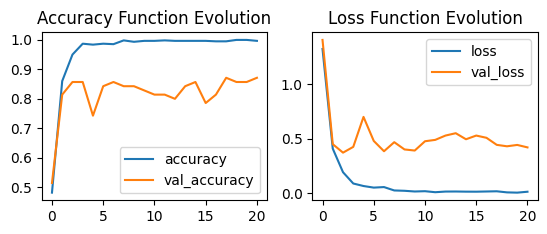

In [ ]:
plt.subplot(2, 2, 1)
plt.plot(mmm.history['accuracy'], label='accuracy')
plt.plot(mmm.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(mmm.history['loss'], label='loss')
plt.plot(mmm.history['val_loss'], label='val_loss')
plt.title('Loss Function Evolution')
plt.legend()

# loading saved model and making predictions

In [ ]:
import tensorflow as tf
modal = tf.keras.models.load_model("/content/drive/MyDrive/soybeanLeafDiseasePrediction.keras")

In [ ]:
pred = modal.predict(x_test)

3/3 [==============================] - 10s 3s/step


# Evaluating Model

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
acc = accuracy_score(y_test, np.argmax(pred, axis=1))
cm = confusion_matrix(y_test, np.argmax(pred, axis=1))
print(acc)
print(cm)

0.8831168831168831
[[13  0  0  0  0  0  0]
 [ 0  8  1  0  0  0  0]
 [ 0  0  8  0  0  0  0]
 [ 1  0  0  5  0  2  0]
 [ 0  4  0  0  7  0  0]
 [ 0  0  0  1  0 13  0]
 [ 0  0  0  0  0  0 14]]


<Axes: >

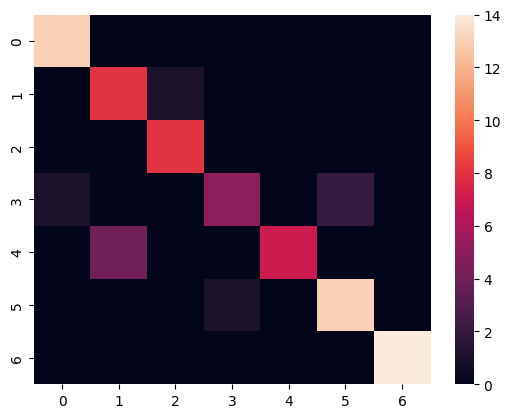

In [ ]:
import seaborn as sns

sns.heatmap(cm)

In [ ]:
score = modal.evaluate(x_test, to_categorical(y_test, 7), verbose = 0)
print(score)

[0.4501417577266693, 0.8831169009208679]


## Testing on unseen data

In [7]:
tf.__version__

'2.14.0'

In [12]:
import tensorflow as tf
import numpy as np
from PIL import Image

cats = {0: 'Bacterial Pustule',
 1: 'Frogeye Leaf Spot',
 2: 'Healthy',
 3: 'Rust',
 4: 'Sudden Death Syndrome',
 5: 'Target Leaf Spot',
 6: 'Yellow Mosaic'}

path = '/content/drive/MyDrive/soybean leaf/soybean-leaf-dataset/Healty/Healthy (22).jpg'

modal = tf.keras.models.load_model("/content/drive/MyDrive/soybean leaf/SLDP.h5")

image = Image.open(path)
image = image.resize((224, 224))
img = np.array(image)
img_batch = np.expand_dims(img, axis=0)
img = img/255

pred_index = np.argmax(modal.predict(img_batch))
pred_class=cats[pred_index]
print("\n{}".format(pred_class))

1/1 [==============================] - 1s 1s/step

Healthy


In [ ]:
modal.save('/content/drive/MyDrive/soybean leaf/SLDP.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(tf.__version__)

2.13.0


In [ ]:
modal.summary()

In [ ]:
import sys
print(sys.version)


3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [ ]:
print(tf.__version__)

2.13.0


In [ ]:
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
print(pd.__version__)
# print(plt.__version__)
print(sk.__version__)

1.5.3
1.2.2
